# new model training for cite Guage

In [23]:
# Memory-Efficient DBLP Citation Network Training Pipeline
# Optimized for laptop/limited memory environments

# ============================================================================
# BLOCK 1: Setup and Configuration
# ============================================================================

import os
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import warnings
from typing import List, Union, Optional, Dict, Any
import joblib
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Memory monitoring function
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

# Enhanced logging configuration
def setup_logging(step_name: str, log_level: int = logging.INFO) -> logging.Logger:
    """Setup logging with memory monitoring"""
    log_filename = f"{step_name}.log"
    
    # Clear existing handlers to prevent duplicates
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s - [MEM: {:.1f}MB] - %(message)s'.format(get_memory_usage())
    )
    
    # Setup handlers
    file_handler = logging.FileHandler(log_filename, mode='w')
    file_handler.setFormatter(formatter)
    
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    
    # Configure root logger
    logging.basicConfig(
        level=log_level,
        handlers=[file_handler, console_handler],
        format='%(asctime)s - %(levelname)s - [MEM: {:.1f}MB] - %(message)s'.format(get_memory_usage())
    )
    
    logger = logging.getLogger(step_name)
    return logger

# Memory management utilities
def force_garbage_collection():
    """Force garbage collection and log memory usage"""
    before_mem = get_memory_usage()
    gc.collect()
    after_mem = get_memory_usage()
    print(f"Memory: {before_mem:.1f}MB -> {after_mem:.1f}MB (freed: {before_mem-after_mem:.1f}MB)")

def check_memory_limit(limit_mb: int = 8192):
    """Check if memory usage exceeds limit"""
    current_mem = get_memory_usage()
    if current_mem > limit_mb:
        print(f"WARNING: Memory usage ({current_mem:.1f}MB) exceeds limit ({limit_mb}MB)")
        force_garbage_collection()
        return True
    return False

# Configuration
CONFIG = {
    'DATA_DIR': Path('data'),
    'KAGGLE_CSV_FILE': 'dblp-citation-network-v14.csv',
    # --- OUTPUT PATHS (Updated to point to Django's ml_models directory) ---
    'ML_MODELS_DIR': Path('../ml_models'),
    'MODEL_PATH': Path('../ml_models') / 'ridge_model.pkl',
    'VECTORIZERS_PATH': Path('../ml_models') / 'tfidf_vectorizers.pkl',
    'MODEL_RESULTS_PATH': Path('../ml_models') / 'model_results.pkl',
    
    # Memory optimization settings
    'CHUNK_SIZE': 10000,  # Process data in chunks
    'MAX_MEMORY_MB': 6144,  # 6GB memory limit
    'DTYPE_OPTIMIZATIONS': {
        'year': 'int16',
        'n_citation': 'int32',
        'has_doi': 'int8',
        'has_url': 'int8',
        'title_length': 'int16',
        'abstract_length': 'int32',
        'num_keywords': 'int16',
        'age': 'int16',
        'num_references': 'int16'
    },
    
    # TF-IDF parameters (reduced for memory efficiency)
    'TFIDF_MAX_FEATURES': 5000,  # Reduced from 10000
    'TFIDF_MIN_DF_TITLE_ABSTRACT': 10,  # Increased to reduce features
    'TFIDF_MIN_DF_KEYWORDS': 2,
    'TFIDF_NGRAM_RANGE': (1, 2),
    
    # Processing settings
    'RANDOM_STATE': 42,
    'N_JOBS': -1  # Use all available cores
}

# Numerical features list
NUMERICAL_FEATURES_COLS = [
    'title_length', 'abstract_length', 'num_keywords',
    'age', 'num_references', 'has_doi', 'has_url'
]

# Create data directory
CONFIG['ML_MODELS_DIR'].mkdir(exist_ok=True)

print("=" * 60)
print("MEMORY-EFFICIENT DBLP CITATION NETWORK TRAINING PIPELINE")
print("=" * 60)
print(f"Initial memory usage: {get_memory_usage():.1f}MB")
print(f"Configuration loaded. Data directory: {CONFIG['DATA_DIR']}")
print(f"Memory limit set to: {CONFIG['MAX_MEMORY_MB']}MB")

MEMORY-EFFICIENT DBLP CITATION NETWORK TRAINING PIPELINE
Initial memory usage: 4243.1MB
Configuration loaded. Data directory: data
Memory limit set to: 6144MB


In [24]:


# ============================================================================
# BLOCK 2: Data Loading with Memory Optimization
# ============================================================================

def load_data_efficiently(file_path: Path, chunk_size: int = 10000) -> pd.DataFrame:
    """Load CSV data efficiently using chunking and memory optimization"""
    import csv
    
    logger = setup_logging("data_loading")
    logger.info("Starting efficient data loading")
    
    full_csv_path = CONFIG['DATA_DIR'] / CONFIG['KAGGLE_CSV_FILE']
    
    if not full_csv_path.exists():
        error_msg = f"Dataset CSV file not found at '{full_csv_path}'"
        logger.error(error_msg)
        raise FileNotFoundError(error_msg)
    
    logger.info(f"Loading data from: {full_csv_path}")
    
    # First, get file size for progress tracking
    file_size = full_csv_path.stat().st_size / 1024 / 1024  # MB
    logger.info(f"File size: {file_size:.1f}MB")
    
    try:
        # Increase CSV field size limit to handle large fields
        csv.field_size_limit(min(2**31-1, 10**7))  # Set to 10MB or system max
        logger.info("CSV field size limit increased for large fields")
        
        # Read in chunks to manage memory
        chunks = []
        total_rows = 0
        
        chunk_reader = pd.read_csv(
            full_csv_path,
            sep='|',
            engine='python',
            on_bad_lines='skip',
            chunksize=chunk_size,
            low_memory=True,
            quoting=csv.QUOTE_NONE,  # Handle quotes more flexibly
            escapechar='\\',         # Handle escape characters
            dtype=str               # Read everything as string first
        )
        
        for i, chunk in enumerate(chunk_reader):
            logger.info(f"Processing chunk {i+1}, rows: {len(chunk)}")
            
            # Basic cleaning on chunk
            chunk = optimize_chunk_dtypes(chunk)
            chunks.append(chunk)
            total_rows += len(chunk)
            
            # Memory check
            if check_memory_limit(CONFIG['MAX_MEMORY_MB']):
                logger.warning(f"Memory limit reached after {i+1} chunks")
                break
        
        logger.info(f"Loaded {len(chunks)} chunks with total {total_rows} rows")
        
        # Combine chunks efficiently
        logger.info("Combining chunks...")
        df = pd.concat(chunks, ignore_index=True)
        del chunks  # Free memory immediately
        force_garbage_collection()
        
        logger.info(f"Final dataset shape: {df.shape}")
        return df
        
    except Exception as e:
        logger.error(f"Error loading data: {e}", exc_info=True)
        raise

def optimize_chunk_dtypes(chunk: pd.DataFrame) -> pd.DataFrame:
    """Optimize data types for a chunk to reduce memory usage"""
    # Convert numeric columns with appropriate dtypes
    if 'year' in chunk.columns:
        chunk['year'] = pd.to_numeric(chunk['year'], errors='coerce', downcast='integer')
    
    if 'n_citation' in chunk.columns:
        chunk['n_citation'] = pd.to_numeric(chunk['n_citation'], errors='coerce', downcast='integer')
    
    # Convert string columns to category if they have low cardinality
    for col in ['lang', 'doc_type']:
        if col in chunk.columns:
            unique_ratio = chunk[col].nunique() / len(chunk)
            if unique_ratio < 0.5:  # If less than 50% unique values
                chunk[col] = chunk[col].astype('category')
    
    return chunk

# Load data
print("\n" + "="*50)
print("LOADING DATA")
print("="*50)

df = load_data_efficiently(CONFIG['DATA_DIR'] / CONFIG['KAGGLE_CSV_FILE'], CONFIG['CHUNK_SIZE'])
print(f"Data loaded successfully. Shape: {df.shape}")
print(f"Memory usage after loading: {get_memory_usage():.1f}MB")

2025-07-20 19:10:48,606 - INFO - [MEM: 4244.6MB] - Starting efficient data loading
2025-07-20 19:10:48,606 - INFO - [MEM: 4244.6MB] - Loading data from: data/dblp-citation-network-v14.csv
2025-07-20 19:10:48,606 - INFO - [MEM: 4244.6MB] - File size: 3128.0MB
2025-07-20 19:10:48,607 - INFO - [MEM: 4244.6MB] - CSV field size limit increased for large fields



LOADING DATA


2025-07-20 19:10:48,884 - INFO - [MEM: 4244.6MB] - Processing chunk 1, rows: 8420
2025-07-20 19:10:49,092 - INFO - [MEM: 4244.6MB] - Processing chunk 2, rows: 9422
2025-07-20 19:10:49,308 - INFO - [MEM: 4244.6MB] - Processing chunk 3, rows: 9483
2025-07-20 19:10:49,450 - INFO - [MEM: 4244.6MB] - Processing chunk 4, rows: 9249
2025-07-20 19:10:49,560 - INFO - [MEM: 4244.6MB] - Processing chunk 5, rows: 9229
2025-07-20 19:10:49,687 - INFO - [MEM: 4244.6MB] - Processing chunk 6, rows: 9220
2025-07-20 19:10:49,795 - INFO - [MEM: 4244.6MB] - Processing chunk 7, rows: 9136
2025-07-20 19:10:49,921 - INFO - [MEM: 4244.6MB] - Processing chunk 8, rows: 9428
2025-07-20 19:10:50,052 - INFO - [MEM: 4244.6MB] - Processing chunk 9, rows: 9508
2025-07-20 19:10:50,210 - INFO - [MEM: 4244.6MB] - Processing chunk 10, rows: 9673
2025-07-20 19:10:50,347 - INFO - [MEM: 4244.6MB] - Processing chunk 11, rows: 9703
2025-07-20 19:10:50,499 - INFO - [MEM: 4244.6MB] - Processing chunk 12, rows: 9737
2025-07-20 19

Memory: 4715.7MB -> 4924.5MB (freed: -208.8MB)
Data loaded successfully. Shape: (2027734, 19)
Memory usage after loading: 5533.9MB


2025-07-20 19:11:37,800 - INFO - [MEM: 5538.8MB] - Starting Memory-Efficient EDA
2025-07-20 19:11:37,800 - INFO - [MEM: 5538.8MB] - Dataset shape: (2027734, 19)



EXPLORATORY DATA ANALYSIS


2025-07-20 19:11:46,430 - INFO - [MEM: 5538.8MB] - Memory usage: 4560.0MB
2025-07-20 19:11:46,430 - INFO - [MEM: 5538.8MB] - Analyzing missing values...
2025-07-20 19:11:47,910 - INFO - [MEM: 5538.8MB] - Columns with missing values: 19
2025-07-20 19:11:47,910 - INFO - [MEM: 5538.8MB] - Analyzing target variable (n_citation)...
2025-07-20 19:11:47,995 - INFO - [MEM: 5538.8MB] - Citation statistics:
count    1.732752e+06
mean     3.947402e+01
std      3.290488e+02
min      0.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.600000e+01
max      1.218600e+05
Name: n_citation, dtype: float64


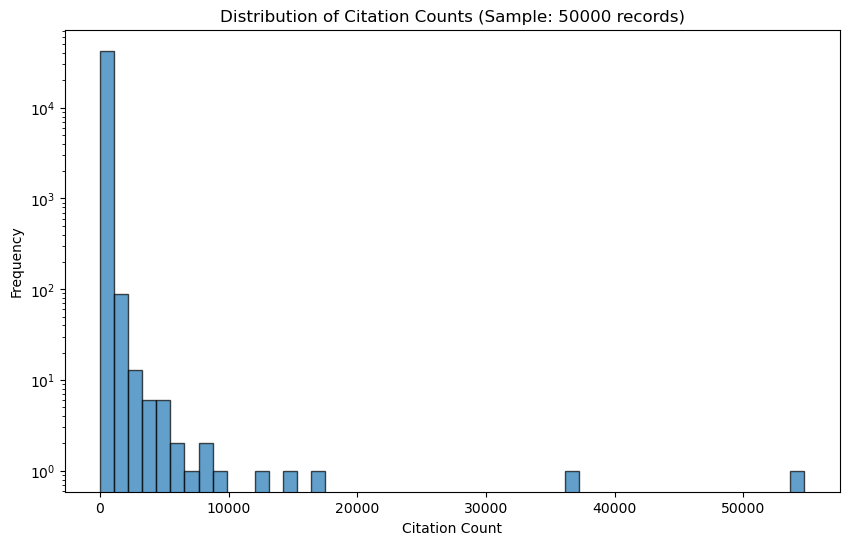

2025-07-20 19:11:48,327 - INFO - [MEM: 5538.8MB] - Analyzing publication years...
2025-07-20 19:11:48,422 - INFO - [MEM: 5538.8MB] - Year statistics:
count    1.732750e+06
mean     2.004538e+03
std      1.014931e+01
min      0.000000e+00
25%      2.001000e+03
50%      2.007000e+03
75%      2.011000e+03
max      2.022000e+03
Name: year, dtype: float64
2025-07-20 19:11:48,423 - INFO - [MEM: 5538.8MB] - Analyzing text fields...
2025-07-20 19:11:48,423 - INFO - [MEM: 5538.8MB] - Analyzing title...


Memory: 8479.9MB -> 8480.1MB (freed: -0.2MB)


2025-07-20 19:11:48,730 - INFO - [MEM: 5538.8MB] - title length statistics (sample):
count    1000.000000
mean       75.714000
std        59.453502
min         7.000000
25%        51.000000
50%        68.000000
75%        87.000000
max       926.000000
Name: title, dtype: float64
2025-07-20 19:11:48,731 - INFO - [MEM: 5538.8MB] - Analyzing abstract...
2025-07-20 19:11:49,193 - INFO - [MEM: 5538.8MB] - abstract length statistics (sample):
count    1000.000000
mean      871.858000
std       433.127937
min         1.000000
25%       582.750000
50%       832.000000
75%      1120.000000
max      2859.000000
Name: abstract, dtype: float64
2025-07-20 19:11:49,194 - INFO - [MEM: 5538.8MB] - Analyzing keywords...
2025-07-20 19:11:49,547 - INFO - [MEM: 5538.8MB] - keywords length statistics (sample):
count    1000.000000
mean      195.489000
std       180.631286
min         2.000000
25%        44.000000
50%       139.500000
75%       315.000000
max      1011.000000
Name: keywords, dtype: float64

EDA completed. Memory usage: 8507.9MB

Top columns with missing values:
          Missing_Count  Missing_Percentage
isbn            1648056           81.275749
issue           1186867           58.531691
issn            1027093           50.652255
volume           940837           46.398443
abstract         610654           30.115094

Citation count statistics:
count    1.732752e+06
mean     3.947402e+01
std      3.290488e+02
min      0.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.600000e+01
max      1.218600e+05
Name: n_citation, dtype: float64


In [25]:


# ============================================================================
# BLOCK 3: Memory-Efficient Exploratory Data Analysis
# ============================================================================

def perform_memory_efficient_eda(df: pd.DataFrame) -> Dict[str, Any]:
    """Perform EDA with memory efficiency in mind"""
    logger = setup_logging("eda")
    logger.info("Starting Memory-Efficient EDA")
    
    eda_results = {}
    
    try:
        # Basic info
        logger.info(f"Dataset shape: {df.shape}")
        logger.info(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
        
        # Missing values analysis
        logger.info("Analyzing missing values...")
        missing_info = df.isnull().sum()
        missing_pct = (missing_info / len(df)) * 100
        
        missing_df = pd.DataFrame({
            'Missing_Count': missing_info,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Percentage', ascending=False)
        
        eda_results['missing_values'] = missing_df[missing_df['Missing_Count'] > 0]
        logger.info(f"Columns with missing values: {len(eda_results['missing_values'])}")
        
        # Target variable analysis (n_citation)
        if 'n_citation' in df.columns:
            logger.info("Analyzing target variable (n_citation)...")
            df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')
            
            citation_stats = df['n_citation'].describe()
            eda_results['citation_stats'] = citation_stats
            logger.info(f"Citation statistics:\n{citation_stats}")
            
            # Create histogram efficiently (sample if dataset is large)
            sample_size = min(50000, len(df))
            sample_df = df.sample(n=sample_size, random_state=CONFIG['RANDOM_STATE'])
            
            plt.figure(figsize=(10, 6))
            plt.hist(sample_df['n_citation'].dropna(), bins=50, alpha=0.7, edgecolor='black')
            plt.title(f'Distribution of Citation Counts (Sample: {sample_size} records)')
            plt.xlabel('Citation Count')
            plt.ylabel('Frequency')
            plt.yscale('log')  # Log scale due to typical skewness
            plt.show()
            
            del sample_df
            force_garbage_collection()
        
        # Year analysis
        if 'year' in df.columns:
            logger.info("Analyzing publication years...")
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
            year_stats = df['year'].describe()
            eda_results['year_stats'] = year_stats
            logger.info(f"Year statistics:\n{year_stats}")
        
        # Text field analysis (sample-based to save memory)
        text_cols = ['title', 'abstract', 'keywords']
        logger.info("Analyzing text fields...")
        
        for col in text_cols:
            if col in df.columns:
                logger.info(f"Analyzing {col}...")
                
                # Sample for analysis
                sample_texts = df[col].dropna().sample(min(1000, df[col].dropna().shape[0]), 
                                                     random_state=CONFIG['RANDOM_STATE'])
                
                if col == 'keywords':
                    # Special handling for keywords
                    sample_lengths = sample_texts.apply(lambda x: len(str(x)))
                else:
                    sample_lengths = sample_texts.str.len()
                
                eda_results[f'{col}_length_stats'] = sample_lengths.describe()
                logger.info(f"{col} length statistics (sample):\n{sample_lengths.describe()}")
        
        logger.info("EDA completed successfully")
        return eda_results
        
    except Exception as e:
        logger.error(f"Error during EDA: {e}", exc_info=True)
        raise

# Perform EDA
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

eda_results = perform_memory_efficient_eda(df)
print(f"EDA completed. Memory usage: {get_memory_usage():.1f}MB")

# Display key findings
if 'missing_values' in eda_results and not eda_results['missing_values'].empty:
    print("\nTop columns with missing values:")
    print(eda_results['missing_values'].head())

if 'citation_stats' in eda_results:
    print(f"\nCitation count statistics:")
    print(eda_results['citation_stats'])

In [26]:

# ============================================================================
# BLOCK 4: Memory-Efficient Data Cleaning
# ============================================================================

import ast
import re
from typing import List, Union

import re

def robust_keyword_parser(keyword_input: Union[str, list, None]) -> List[str]:
    """Robustly parse keywords with memory efficiency and escape issues fixed"""
    if pd.isna(keyword_input) or keyword_input in ['[]', '{}', 'None', 'none', 'null', '']:
        return []
    
    if isinstance(keyword_input, list):
        return clean_keyword_list(keyword_input)
    
    keyword_str = str(keyword_input).strip()

    # Escape invalid backslashes to avoid SyntaxWarnings
    keyword_str = re.sub(r'\\(?![nrt\\"])', r'\\\\', keyword_str)

    # Try parsing as literal
    if keyword_str.startswith('[') and keyword_str.endswith(']'):
        try:
            parsed = ast.literal_eval(keyword_str)
            if isinstance(parsed, list):
                return clean_keyword_list(parsed)
        except (ValueError, SyntaxError):
            pass

    # Fallback to comma separation
    if ',' in keyword_str:
        keywords = [kw.strip() for kw in keyword_str.split(',')]
        return clean_keyword_list(keywords)
    
    # Space separation as last resort
    keywords = keyword_str.split()
    return clean_keyword_list(keywords)


def clean_keyword_list(keyword_list: List[Union[str, int, float]]) -> List[str]:
    """Clean individual keywords in a list"""
    cleaned = []
    blacklist = {'', 'none', 'null', 'na', 'n/a', 'keyword', 'keywords', 'none type'}
    
    for kw in keyword_list:
        if pd.isna(kw):
            continue
            
        kw_str = str(kw).strip().lower()
        kw_str = re.sub(r'[^\w\s\-]', '', kw_str)  # Escaped hyphen

        
        if (len(kw_str) > 1 and 
            not kw_str.isnumeric() and 
            kw_str not in blacklist):
            cleaned.append(kw_str)
    
    return list(set(cleaned))

def clean_data_efficiently(df: pd.DataFrame) -> pd.DataFrame:
    """Clean data with memory optimization"""
    logger = setup_logging("data_cleaning")
    logger.info(f"Starting data cleaning on {len(df)} records")
    
    initial_memory = get_memory_usage()
    
    try:
        # Drop unnecessary columns
        columns_to_drop = ['authors']
        existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
        if existing_cols_to_drop:
            df = df.drop(columns=existing_cols_to_drop)
            logger.info(f"Dropped columns: {existing_cols_to_drop}")
            force_garbage_collection()
        
        # Handle target variable (n_citation)
        if 'n_citation' in df.columns:
            initial_len = len(df)
            df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')
            df = df.dropna(subset=['n_citation'])
            df['n_citation'] = df['n_citation'].astype(CONFIG['DTYPE_OPTIMIZATIONS']['n_citation'])
            logger.info(f"Removed {initial_len - len(df)} rows with missing citations")
        
        # Handle year
        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
            mode_year = int(df['year'].mode()[0]) if not df['year'].mode().empty else 2000
            df['year'] = df['year'].fillna(mode_year).astype(CONFIG['DTYPE_OPTIMIZATIONS']['year'])
            logger.info(f"Filled missing years with mode: {mode_year}")
        
        # Process keywords in chunks to manage memory
        if 'keywords' in df.columns:
            logger.info("Processing keywords...")
            chunk_size = 5000

            for i in range(0, len(df), chunk_size):
                chunk_end = min(i + chunk_size, len(df))
                df.loc[df.index[i:chunk_end], 'keywords'] = df['keywords'].iloc[i:chunk_end].apply(robust_keyword_parser)

                if i % 20000 == 0:  # Progress update every 20k records
                    logger.info(f"Processed keywords for {chunk_end}/{len(df)} records")
                    check_memory_limit(CONFIG['MAX_MEMORY_MB'])

            logger.info("Keywords processing completed")
            force_garbage_collection()

        
        # Clean text fields efficiently
        text_cols = ['title', 'abstract', 'venue', 'doc_type']
        for col in text_cols:
            if col in df.columns:
                df[col] = df[col].fillna("").astype(str).str.strip().str.lower()
                df[col] = df[col].replace({'none': '', 'null': '', 'nan': ''})
                logger.info(f"Cleaned text column: {col}")
        
        # Handle references
        if 'references' in df.columns:
            logger.info("Processing references...")
            def safe_reference_parser(ref):
                if isinstance(ref, list):
                    return ref
                try:
                    if isinstance(ref, str) and ref.startswith('['):
                        return ast.literal_eval(ref)
                except Exception:
                    return []
                return []
            df['references'] = df['references'].apply(safe_reference_parser)
            logger.info("References processed")
        
        # Memory optimization - convert to optimal dtypes
        for col, dtype in CONFIG['DTYPE_OPTIMIZATIONS'].items():
            if col in df.columns:
                df[col] = df[col].astype(dtype)
        
        logger.info(f"Data cleaning completed. Shape: {df.shape}")
        logger.info(f"Memory usage: {initial_memory:.1f}MB -> {get_memory_usage():.1f}MB")
        
        return df
        
    except Exception as e:
        logger.error(f"Error during data cleaning: {e}", exc_info=True)
        raise

# Clean data
print("\n" + "="*50)
print("DATA CLEANING")
print("="*50)

df_clean = clean_data_efficiently(df)
print(f"Data cleaning completed. Final shape: {df_clean.shape}")
print(f"Memory usage after cleaning: {get_memory_usage():.1f}MB")

# Save cleaned data
cleaned_path = CONFIG['DATA_DIR'] / CONFIG['CLEANED_PARQUET_FILE']
df_clean.to_parquet(cleaned_path, index=False)
print(f"Cleaned data saved to: {cleaned_path}")

# Free memory
del df
force_garbage_collection()


2025-07-20 19:11:49,567 - INFO - [MEM: 8508.2MB] - Starting data cleaning on 2027734 records



DATA CLEANING


2025-07-20 19:11:49,915 - INFO - [MEM: 8508.2MB] - Dropped columns: ['authors']


Memory: 8533.5MB -> 8533.5MB (freed: 0.0MB)


2025-07-20 19:11:50,522 - INFO - [MEM: 8508.2MB] - Removed 294982 rows with missing citations
2025-07-20 19:11:50,560 - INFO - [MEM: 8508.2MB] - Filled missing years with mode: 2012
2025-07-20 19:11:50,561 - INFO - [MEM: 8508.2MB] - Processing keywords...
2025-07-20 19:11:50,723 - INFO - [MEM: 8508.2MB] - Processed keywords for 5000/1732752 records


Memory: 8897.0MB -> 8897.0MB (freed: 0.0MB)


2025-07-20 19:11:51,225 - INFO - [MEM: 8508.2MB] - Processed keywords for 25000/1732752 records


Memory: 8897.1MB -> 8897.1MB (freed: 0.0MB)


2025-07-20 19:11:52,162 - INFO - [MEM: 8508.2MB] - Processed keywords for 45000/1732752 records


Memory: 8897.2MB -> 8897.2MB (freed: 0.0MB)


2025-07-20 19:11:52,930 - INFO - [MEM: 8508.2MB] - Processed keywords for 65000/1732752 records


Memory: 8897.3MB -> 8897.3MB (freed: 0.0MB)


2025-07-20 19:11:53,684 - INFO - [MEM: 8508.2MB] - Processed keywords for 85000/1732752 records


Memory: 8897.5MB -> 8897.5MB (freed: 0.0MB)


2025-07-20 19:11:54,447 - INFO - [MEM: 8508.2MB] - Processed keywords for 105000/1732752 records


Memory: 8897.6MB -> 8897.6MB (freed: 0.0MB)


2025-07-20 19:11:55,226 - INFO - [MEM: 8508.2MB] - Processed keywords for 125000/1732752 records


Memory: 8897.6MB -> 8897.6MB (freed: 0.0MB)


2025-07-20 19:11:56,011 - INFO - [MEM: 8508.2MB] - Processed keywords for 145000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:11:56,707 - INFO - [MEM: 8508.2MB] - Processed keywords for 165000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:11:57,392 - INFO - [MEM: 8508.2MB] - Processed keywords for 185000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:11:58,142 - INFO - [MEM: 8508.2MB] - Processed keywords for 205000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:11:59,097 - INFO - [MEM: 8508.2MB] - Processed keywords for 225000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:11:59,883 - INFO - [MEM: 8508.2MB] - Processed keywords for 245000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:00,906 - INFO - [MEM: 8508.2MB] - Processed keywords for 265000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:01,764 - INFO - [MEM: 8508.2MB] - Processed keywords for 285000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:02,607 - INFO - [MEM: 8508.2MB] - Processed keywords for 305000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:03,407 - INFO - [MEM: 8508.2MB] - Processed keywords for 325000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:04,222 - INFO - [MEM: 8508.2MB] - Processed keywords for 345000/1732752 records


Memory: 8897.7MB -> 8897.7MB (freed: 0.0MB)


2025-07-20 19:12:05,049 - INFO - [MEM: 8508.2MB] - Processed keywords for 365000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:05,899 - INFO - [MEM: 8508.2MB] - Processed keywords for 385000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:06,948 - INFO - [MEM: 8508.2MB] - Processed keywords for 405000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:07,952 - INFO - [MEM: 8508.2MB] - Processed keywords for 425000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:08,848 - INFO - [MEM: 8508.2MB] - Processed keywords for 445000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:09,721 - INFO - [MEM: 8508.2MB] - Processed keywords for 465000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:10,562 - INFO - [MEM: 8508.2MB] - Processed keywords for 485000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:11,438 - INFO - [MEM: 8508.2MB] - Processed keywords for 505000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:12,338 - INFO - [MEM: 8508.2MB] - Processed keywords for 525000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:13,231 - INFO - [MEM: 8508.2MB] - Processed keywords for 545000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:14,139 - INFO - [MEM: 8508.2MB] - Processed keywords for 565000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:15,048 - INFO - [MEM: 8508.2MB] - Processed keywords for 585000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:15,968 - INFO - [MEM: 8508.2MB] - Processed keywords for 605000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:16,917 - INFO - [MEM: 8508.2MB] - Processed keywords for 625000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:17,926 - INFO - [MEM: 8508.2MB] - Processed keywords for 645000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:18,896 - INFO - [MEM: 8508.2MB] - Processed keywords for 665000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:19,877 - INFO - [MEM: 8508.2MB] - Processed keywords for 685000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:21,100 - INFO - [MEM: 8508.2MB] - Processed keywords for 705000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:22,368 - INFO - [MEM: 8508.2MB] - Processed keywords for 725000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:23,588 - INFO - [MEM: 8508.2MB] - Processed keywords for 745000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:24,761 - INFO - [MEM: 8508.2MB] - Processed keywords for 765000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:25,755 - INFO - [MEM: 8508.2MB] - Processed keywords for 785000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:26,694 - INFO - [MEM: 8508.2MB] - Processed keywords for 805000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:27,666 - INFO - [MEM: 8508.2MB] - Processed keywords for 825000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:28,897 - INFO - [MEM: 8508.2MB] - Processed keywords for 845000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:30,072 - INFO - [MEM: 8508.2MB] - Processed keywords for 865000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:31,135 - INFO - [MEM: 8508.2MB] - Processed keywords for 885000/1732752 records


Memory: 8898.0MB -> 8898.0MB (freed: 0.0MB)


2025-07-20 19:12:32,187 - INFO - [MEM: 8508.2MB] - Processed keywords for 905000/1732752 records


Memory: 8898.0MB -> 8898.0MB (freed: 0.0MB)


2025-07-20 19:12:33,252 - INFO - [MEM: 8508.2MB] - Processed keywords for 925000/1732752 records


Memory: 8898.0MB -> 8898.0MB (freed: 0.0MB)


2025-07-20 19:12:34,312 - INFO - [MEM: 8508.2MB] - Processed keywords for 945000/1732752 records


Memory: 8898.0MB -> 8898.0MB (freed: 0.0MB)


2025-07-20 19:12:35,333 - INFO - [MEM: 8508.2MB] - Processed keywords for 965000/1732752 records


Memory: 8898.0MB -> 8898.0MB (freed: 0.0MB)


2025-07-20 19:12:36,382 - INFO - [MEM: 8508.2MB] - Processed keywords for 985000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:37,791 - INFO - [MEM: 8508.2MB] - Processed keywords for 1005000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:39,015 - INFO - [MEM: 8508.2MB] - Processed keywords for 1025000/1732752 records


Memory: 8897.8MB -> 8897.8MB (freed: 0.0MB)


2025-07-20 19:12:40,196 - INFO - [MEM: 8508.2MB] - Processed keywords for 1045000/1732752 records


Memory: 8830.9MB -> 8820.7MB (freed: 10.2MB)


2025-07-20 19:12:41,526 - INFO - [MEM: 8508.2MB] - Processed keywords for 1065000/1732752 records


Memory: 8820.7MB -> 8820.7MB (freed: 0.0MB)


2025-07-20 19:12:42,639 - INFO - [MEM: 8508.2MB] - Processed keywords for 1085000/1732752 records


Memory: 8820.7MB -> 8820.7MB (freed: 0.0MB)


2025-07-20 19:12:43,668 - INFO - [MEM: 8508.2MB] - Processed keywords for 1105000/1732752 records


Memory: 8820.7MB -> 8820.7MB (freed: 0.0MB)


2025-07-20 19:12:44,720 - INFO - [MEM: 8508.2MB] - Processed keywords for 1125000/1732752 records


Memory: 8820.7MB -> 8820.7MB (freed: 0.0MB)


2025-07-20 19:12:45,791 - INFO - [MEM: 8508.2MB] - Processed keywords for 1145000/1732752 records


Memory: 8821.2MB -> 8821.2MB (freed: 0.0MB)


2025-07-20 19:12:46,874 - INFO - [MEM: 8508.2MB] - Processed keywords for 1165000/1732752 records


Memory: 8821.2MB -> 8821.2MB (freed: 0.0MB)


2025-07-20 19:12:47,985 - INFO - [MEM: 8508.2MB] - Processed keywords for 1185000/1732752 records


Memory: 8821.2MB -> 8821.2MB (freed: 0.0MB)


2025-07-20 19:12:49,073 - INFO - [MEM: 8508.2MB] - Processed keywords for 1205000/1732752 records


Memory: 8821.2MB -> 8821.2MB (freed: 0.0MB)


2025-07-20 19:12:50,260 - INFO - [MEM: 8508.2MB] - Processed keywords for 1225000/1732752 records


Memory: 8821.2MB -> 8821.2MB (freed: 0.0MB)


2025-07-20 19:12:51,532 - INFO - [MEM: 8508.2MB] - Processed keywords for 1245000/1732752 records


Memory: 8796.0MB -> 8786.5MB (freed: 9.5MB)


2025-07-20 19:12:53,010 - INFO - [MEM: 8508.2MB] - Processed keywords for 1265000/1732752 records


Memory: 8786.5MB -> 8786.5MB (freed: 0.0MB)


2025-07-20 19:12:54,239 - INFO - [MEM: 8508.2MB] - Processed keywords for 1285000/1732752 records


Memory: 8786.5MB -> 8786.5MB (freed: 0.0MB)


2025-07-20 19:12:55,381 - INFO - [MEM: 8508.2MB] - Processed keywords for 1305000/1732752 records


Memory: 8786.5MB -> 8786.5MB (freed: 0.0MB)


2025-07-20 19:12:56,494 - INFO - [MEM: 8508.2MB] - Processed keywords for 1325000/1732752 records


Memory: 8786.5MB -> 8786.5MB (freed: 0.0MB)


2025-07-20 19:12:57,705 - INFO - [MEM: 8508.2MB] - Processed keywords for 1345000/1732752 records


Memory: 8786.5MB -> 8734.5MB (freed: 52.1MB)


2025-07-20 19:12:59,355 - INFO - [MEM: 8508.2MB] - Processed keywords for 1365000/1732752 records


Memory: 8713.2MB -> 8670.6MB (freed: 42.7MB)


2025-07-20 19:13:00,785 - INFO - [MEM: 8508.2MB] - Processed keywords for 1385000/1732752 records


Memory: 8669.0MB -> 8669.0MB (freed: 0.0MB)


2025-07-20 19:13:02,100 - INFO - [MEM: 8508.2MB] - Processed keywords for 1405000/1732752 records


Memory: 8669.0MB -> 8669.0MB (freed: 0.0MB)


2025-07-20 19:13:03,324 - INFO - [MEM: 8508.2MB] - Processed keywords for 1425000/1732752 records


Memory: 8669.0MB -> 8669.0MB (freed: 0.0MB)


2025-07-20 19:13:04,540 - INFO - [MEM: 8508.2MB] - Processed keywords for 1445000/1732752 records


Memory: 8669.0MB -> 8669.0MB (freed: 0.0MB)


2025-07-20 19:13:05,739 - INFO - [MEM: 8508.2MB] - Processed keywords for 1465000/1732752 records


Memory: 8669.0MB -> 8627.2MB (freed: 41.8MB)


2025-07-20 19:13:07,471 - INFO - [MEM: 8508.2MB] - Processed keywords for 1485000/1732752 records


Memory: 8545.9MB -> 8546.0MB (freed: -0.0MB)


2025-07-20 19:13:08,772 - INFO - [MEM: 8508.2MB] - Processed keywords for 1505000/1732752 records


Memory: 8546.0MB -> 8546.0MB (freed: 0.0MB)


2025-07-20 19:13:09,932 - INFO - [MEM: 8508.2MB] - Processed keywords for 1525000/1732752 records


Memory: 8546.0MB -> 8546.0MB (freed: 0.0MB)


2025-07-20 19:13:11,119 - INFO - [MEM: 8508.2MB] - Processed keywords for 1545000/1732752 records


Memory: 8546.0MB -> 8199.1MB (freed: 346.9MB)


2025-07-20 19:13:13,016 - INFO - [MEM: 8508.2MB] - Processed keywords for 1565000/1732752 records


Memory: 7964.6MB -> 7947.5MB (freed: 17.2MB)


2025-07-20 19:13:14,416 - INFO - [MEM: 8508.2MB] - Processed keywords for 1585000/1732752 records


Memory: 7945.8MB -> 7945.8MB (freed: 0.0MB)


2025-07-20 19:13:15,758 - INFO - [MEM: 8508.2MB] - Processed keywords for 1605000/1732752 records


Memory: 7935.2MB -> 7935.2MB (freed: 0.0MB)


2025-07-20 19:13:17,082 - INFO - [MEM: 8508.2MB] - Processed keywords for 1625000/1732752 records


Memory: 7880.0MB -> 7880.0MB (freed: 0.0MB)


2025-07-20 19:13:18,403 - INFO - [MEM: 8508.2MB] - Processed keywords for 1645000/1732752 records


Memory: 7857.6MB -> 7822.1MB (freed: 35.5MB)


2025-07-20 19:13:19,948 - INFO - [MEM: 8508.2MB] - Processed keywords for 1665000/1732752 records


Memory: 7643.5MB -> 7639.6MB (freed: 3.9MB)


2025-07-20 19:13:22,096 - INFO - [MEM: 8508.2MB] - Processed keywords for 1685000/1732752 records


Memory: 7603.5MB -> 7603.5MB (freed: 0.0MB)


2025-07-20 19:13:23,567 - INFO - [MEM: 8508.2MB] - Processed keywords for 1705000/1732752 records


Memory: 7607.4MB -> 7607.4MB (freed: 0.0MB)


2025-07-20 19:13:24,810 - INFO - [MEM: 8508.2MB] - Processed keywords for 1725000/1732752 records


Memory: 7616.1MB -> 7616.1MB (freed: 0.0MB)


2025-07-20 19:13:25,735 - INFO - [MEM: 8508.2MB] - Keywords processing completed


Memory: 7619.3MB -> 7619.3MB (freed: 0.0MB)


2025-07-20 19:13:27,608 - INFO - [MEM: 8508.2MB] - Cleaned text column: title
2025-07-20 19:13:32,317 - INFO - [MEM: 8508.2MB] - Cleaned text column: abstract
2025-07-20 19:13:33,870 - INFO - [MEM: 8508.2MB] - Cleaned text column: venue
2025-07-20 19:13:34,807 - INFO - [MEM: 8508.2MB] - Cleaned text column: doc_type
2025-07-20 19:13:34,807 - INFO - [MEM: 8508.2MB] - Processing references...
2025-07-20 19:14:06,889 - INFO - [MEM: 8508.2MB] - References processed
2025-07-20 19:14:06,903 - INFO - [MEM: 8508.2MB] - Data cleaning completed. Shape: (1732752, 18)
2025-07-20 19:14:06,904 - INFO - [MEM: 8508.2MB] - Memory usage: 8508.2MB -> 5753.4MB


Data cleaning completed. Final shape: (1732752, 18)
Memory usage after cleaning: 5753.6MB
Cleaned data saved to: data/dblp_cleaned.parquet
Memory: 6295.8MB -> 7430.1MB (freed: -1134.3MB)


In [27]:


# ============================================================================
# BLOCK 5: Memory-Efficient Feature Engineering - Numerical Features
# ============================================================================

def create_numerical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create numerical features efficiently"""
    logger = setup_logging("numerical_features")
    logger.info("Creating numerical features")
    
    try:
        # Title length
        if 'title' in df.columns:
            df['title_length'] = df['title'].astype(str).str.len().astype(CONFIG['DTYPE_OPTIMIZATIONS']['title_length'])
            logger.info("Created title_length feature")
        else:
            df['title_length'] = 0
            logger.warning("Title column not found, defaulting title_length to 0")
        
        # Abstract length
        if 'abstract' in df.columns:
            df['abstract_length'] = df['abstract'].astype(str).str.len().astype(CONFIG['DTYPE_OPTIMIZATIONS']['abstract_length'])
            logger.info("Created abstract_length feature")
        else:
            df['abstract_length'] = 0
            logger.warning("Abstract column not found, defaulting abstract_length to 0")
        
        # Number of keywords
        if 'keywords' in df.columns:
            df['num_keywords'] = df['keywords'].apply(len).astype(CONFIG['DTYPE_OPTIMIZATIONS']['num_keywords'])
            logger.info("Created num_keywords feature")
        else:
            df['num_keywords'] = 0
            logger.warning("Keywords column not found, defaulting num_keywords to 0")
        
        # Age of publication
        if 'year' in df.columns:
            current_year = pd.Timestamp.now().year
            df['age'] = (current_year - df['year']).clip(lower=0).astype(CONFIG['DTYPE_OPTIMIZATIONS']['age'])
            logger.info("Created age feature")
        else:
            df['age'] = 0
            logger.warning("Year column not found, defaulting age to 0")
        
        # Number of references
        if 'references' in df.columns:
            df['num_references'] = df['references'].apply(len).astype(CONFIG['DTYPE_OPTIMIZATIONS']['num_references'])
            logger.info("Created num_references feature")
        else:
            df['num_references'] = 0
            logger.warning("References column not found, defaulting num_references to 0")
        
        # Boolean features
        df['has_doi'] = df['doi'].notna().astype(CONFIG['DTYPE_OPTIMIZATIONS']['has_doi']) if 'doi' in df.columns else 0
        df['has_url'] = df['url'].notna().astype(CONFIG['DTYPE_OPTIMIZATIONS']['has_url']) if 'url' in df.columns else 0
        
        logger.info("All numerical features created successfully")
        return df
        
    except Exception as e:
        logger.error(f"Error creating numerical features: {e}", exc_info=True)
        raise

# Create numerical features
print("\n" + "="*50)
print("CREATING NUMERICAL FEATURES")
print("="*50)

df_features = create_numerical_features(df_clean)
print(f"Numerical features created. Memory usage: {get_memory_usage():.1f}MB")

# Verify numerical features
print("\nNumerical feature statistics:")
for col in NUMERICAL_FEATURES_COLS:
    if col in df_features.columns:
        stats = df_features[col].describe()
        print(f"{col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, max={stats['max']}")

2025-07-20 19:14:34,679 - INFO - [MEM: 7431.6MB] - Creating numerical features



CREATING NUMERICAL FEATURES


2025-07-20 19:14:35,105 - INFO - [MEM: 7431.6MB] - Created title_length feature
2025-07-20 19:14:36,253 - INFO - [MEM: 7431.6MB] - Created abstract_length feature
2025-07-20 19:14:37,126 - INFO - [MEM: 7431.6MB] - Created num_keywords feature
2025-07-20 19:14:37,142 - INFO - [MEM: 7431.6MB] - Created age feature
2025-07-20 19:14:37,776 - INFO - [MEM: 7431.6MB] - Created num_references feature
2025-07-20 19:14:38,020 - INFO - [MEM: 7431.6MB] - All numerical features created successfully


Numerical features created. Memory usage: 9296.4MB

Numerical feature statistics:
title_length: mean=70.25, std=27.32, max=900.0
abstract_length: mean=708.48, std=572.34, max=72632.0
num_keywords: mean=8.87, std=7.88, max=141.0
age: mean=20.46, std=10.15, max=2025.0
num_references: mean=7.44, std=10.37, max=1930.0
has_doi: mean=0.82, std=0.38, max=1.0
has_url: mean=1.00, std=0.06, max=1.0


In [28]:


# ============================================================================
# BLOCK 6: Memory-Efficient TF-IDF Feature Engineering
# ============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, coo_matrix, save_npz, csr_matrix
import joblib

def create_tfidf_features_efficiently(df: pd.DataFrame) -> tuple:
    """Create TF-IDF features with memory optimization"""
    logger = setup_logging("tfidf_features")
    logger.info("Starting TF-IDF feature creation")
    
    vectorizers = {}
    sparse_features = []
    
    try:
        # Process each text field separately to manage memory
        text_fields = ['title', 'abstract', 'keywords']
        
        for field in text_fields:
            logger.info(f"Processing TF-IDF for {field}...")
            
            if field not in df.columns:
                logger.warning(f"{field} column not found, skipping")
                sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
                continue
            
            try:
                # Prepare text data
                if field == 'keywords':
                    text_data = df[field].apply(
                        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
                    ).fillna('')
                else:
                    text_data = df[field].astype(str).fillna('')
                
                # Check for empty documents
                non_empty_mask = text_data.str.strip().astype(bool)
                non_empty_count = non_empty_mask.sum()
                
                if non_empty_count == 0:
                    logger.warning(f"All {field} documents are empty")
                    sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
                    continue
                
                # Configure vectorizer based on field
                if field == 'keywords':
                    vectorizer = TfidfVectorizer(
                        max_features=CONFIG['TFIDF_MAX_FEATURES'] // 2,  # Smaller for keywords
                        min_df=CONFIG['TFIDF_MIN_DF_KEYWORDS'],
                        ngram_range=(1, 1),  # Only unigrams for keywords
                        stop_words=None,
                        token_pattern=r'\S+',
                        dtype=np.float32  # Use float32 to save memory
                    )
                else:
                    vectorizer = TfidfVectorizer(
                        max_features=CONFIG['TFIDF_MAX_FEATURES'],
                        min_df=CONFIG['TFIDF_MIN_DF_TITLE_ABSTRACT'],
                        ngram_range=CONFIG['TFIDF_NGRAM_RANGE'],
                        stop_words='english',
                        dtype=np.float32
                    )
                
                # Fit and transform
                tfidf_matrix = vectorizer.fit_transform(text_data)
                
                # Convert to CSR for efficiency
                if not isinstance(tfidf_matrix, csr_matrix):
                    tfidf_matrix = tfidf_matrix.tocsr()
                
                sparse_features.append(tfidf_matrix)
                vectorizers[field] = vectorizer
                
                logger.info(f"{field} TF-IDF shape: {tfidf_matrix.shape}, "
                           f"sparsity: {1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]):.4f}")
                
                # Clean up temporary variables
                del text_data, tfidf_matrix
                check_memory_limit(CONFIG['MAX_MEMORY_MB'])
                
            except Exception as e:
                logger.error(f"Error processing {field}: {e}")
                sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
        
        # Combine sparse features efficiently
        logger.info("Combining sparse features...")
        if sparse_features:
            combined_features = hstack(sparse_features, format='csr', dtype=np.float32)
            logger.info(f"Combined TF-IDF features shape: {combined_features.shape}")
        else:
            combined_features = coo_matrix((len(df), 0), dtype=np.float32)
            logger.warning("No TF-IDF features generated")
        
        return combined_features, vectorizers
        
    except Exception as e:
        logger.error(f"Error in TF-IDF feature creation: {e}", exc_info=True)
        raise

# Create TF-IDF features
print("\n" + "="*50)
print("CREATING TF-IDF FEATURES")
print("="*50)

combined_tfidf, vectorizers = create_tfidf_features_efficiently(df_features)
print(f"TF-IDF features created. Shape: {combined_tfidf.shape}")
print(f"Memory usage: {get_memory_usage():.1f}MB")

# Save TF-IDF features and vectorizers
print("Saving TF-IDF features and vectorizers...")
# We don't need to save the combined features, just the vectorizers for the app
# save_npz(CONFIG['TFIDF_COMBINED_FEATURES_PATH'], combined_tfidf)
joblib.dump(vectorizers, CONFIG['VECTORIZERS_PATH'])
print(f"Vectorizers saved to: {CONFIG['VECTORIZERS_PATH']}")

2025-07-20 19:14:38,257 - INFO - [MEM: 9309.0MB] - Starting TF-IDF feature creation
2025-07-20 19:14:38,258 - INFO - [MEM: 9309.0MB] - Processing TF-IDF for title...



CREATING TF-IDF FEATURES


2025-07-20 19:15:11,520 - INFO - [MEM: 9309.0MB] - title TF-IDF shape: (1732752, 5000), sparsity: 0.9987
2025-07-20 19:15:11,522 - INFO - [MEM: 9309.0MB] - Processing TF-IDF for abstract...
2025-07-20 19:21:29,579 - INFO - [MEM: 9309.0MB] - abstract TF-IDF shape: (1732752, 5000), sparsity: 0.9917
2025-07-20 19:21:29,582 - INFO - [MEM: 9309.0MB] - Processing TF-IDF for keywords...
2025-07-20 19:22:00,748 - INFO - [MEM: 9309.0MB] - keywords TF-IDF shape: (1732752, 2500), sparsity: 0.9953
2025-07-20 19:22:00,752 - INFO - [MEM: 9309.0MB] - Combining sparse features...
2025-07-20 19:22:03,424 - INFO - [MEM: 9309.0MB] - Combined TF-IDF features shape: (1732752, 12500)


TF-IDF features created. Shape: (1732752, 12500)
Memory usage: 2208.8MB
Saving TF-IDF features and vectorizers...
TF-IDF features saved to: data/tfidf_combined_sparse_features.npz
Vectorizers saved to: data/tfidf_vectorizers.pkl


In [29]:


# ============================================================================
# BLOCK 7: Final Data Preparation and Saving
# ============================================================================

def finalize_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Final dataset preparation with memory optimization"""
    logger = setup_logging("finalize_dataset")
    logger.info("Finalizing dataset")
    
    try:
        # Ensure all numerical features exist with correct dtypes
        for col in NUMERICAL_FEATURES_COLS:
            if col in df.columns:
                if col in CONFIG['DTYPE_OPTIMIZATIONS']:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                    df[col] = df[col].astype(CONFIG['DTYPE_OPTIMIZATIONS'][col])
            else:
                # Add missing feature with default value
                default_dtype = CONFIG['DTYPE_OPTIMIZATIONS'].get(col, 'float32')
                df[col] = pd.Series(0, index=df.index, dtype=default_dtype)
                logger.warning(f"Added missing feature {col} with default value 0")
        
        # Final data quality checks
        logger.info("Performing final data quality checks...")
        
        # Check for infinite values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        inf_counts = {}
        for col in numeric_cols:
            inf_count = np.isinf(df[col]).sum()
            if inf_count > 0:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(df[col].median())
                inf_counts[col] = inf_count
        
        if inf_counts:
            logger.warning(f"Replaced infinite values in columns: {inf_counts}")
        
        # Final memory optimization
        memory_before = df.memory_usage(deep=True).sum() / 1024**2
        
        # Optimize string columns
        string_cols = df.select_dtypes(include=['object']).columns
        for col in string_cols:

        # Optimize string columns
            string_cols = df.select_dtypes(include=['object']).columns
            for col in string_cols:
                if col in ['title', 'abstract', 'venue', 'doc_type', 'lang']:
                    unique_ratio = df[col].nunique() / len(df)
                    if unique_ratio < 0.1:  # Less than 10% unique values
                        df[col] = df[col].astype('category')
                        logger.info(f"Converted {col} to category dtype")
            
            memory_after = df.memory_usage(deep=True).sum() / 1024**2
            logger.info(f"Memory optimization: {memory_before:.1f}MB -> {memory_after:.1f}MB")
            
            # Final dataset summary
            logger.info(f"Final dataset shape: {df.shape}")
            logger.info(f"Target variable (n_citation) range: {df['n_citation'].min()} - {df['n_citation'].max()}")
            logger.info(f"Available features: {list(df.columns)}")
            
            return df
        
    except Exception as e:
        logger.error(f"Error finalizing dataset: {e}", exc_info=True)
        raise

# Finalize the dataset
print("\n" + "="*50)
print("FINALIZING DATASET")
print("="*50)

df_final = finalize_dataset(df_features)
print(f"Dataset finalized. Shape: {df_final.shape}")
print(f"Memory usage: {get_memory_usage():.1f}MB")

# Save the final processed dataset
final_processed_path = CONFIG['DATA_DIR'] / 'dblp_final_processed.parquet'
df_final.to_parquet(final_processed_path, index=False)
print(f"Final processed dataset saved to: {final_processed_path}")

# Create a summary of numerical features for later use
numerical_summary = df_final[NUMERICAL_FEATURES_COLS].describe()
summary_path = CONFIG['DATA_DIR'] / 'numerical_features_summary.csv'
numerical_summary.to_csv(summary_path)
print(f"Numerical features summary saved to: {summary_path}")

2025-07-20 19:23:04,069 - INFO - [MEM: 3196.0MB] - Finalizing dataset
2025-07-20 19:23:04,129 - INFO - [MEM: 3196.0MB] - Performing final data quality checks...



FINALIZING DATASET


2025-07-20 19:23:22,816 - INFO - [MEM: 3196.0MB] - Converted lang to category dtype
2025-07-20 19:23:23,243 - INFO - [MEM: 3196.0MB] - Converted venue to category dtype
2025-07-20 19:23:30,402 - INFO - [MEM: 3196.0MB] - Converted doc_type to category dtype
2025-07-20 19:23:38,023 - INFO - [MEM: 3196.0MB] - Memory optimization: 3579.9MB -> 3272.6MB
2025-07-20 19:23:38,024 - INFO - [MEM: 3196.0MB] - Final dataset shape: (1732752, 25)
2025-07-20 19:23:38,030 - INFO - [MEM: 3196.0MB] - Target variable (n_citation) range: 0 - 121860
2025-07-20 19:23:38,030 - INFO - [MEM: 3196.0MB] - Available features: ['id', 'title', 'doi', 'issue', 'keywords', 'lang', 'venue', 'year', 'n_citation', 'page_start', 'page_end', 'volume', 'issn', 'isbn', 'url', 'abstract', 'doc_type', 'references', 'title_length', 'abstract_length', 'num_keywords', 'age', 'num_references', 'has_doi', 'has_url']


Dataset finalized. Shape: (1732752, 25)
Memory usage: 4993.6MB
Final processed dataset saved to: data/dblp_final_processed.parquet
Numerical features summary saved to: data/numerical_features_summary.csv


In [30]:


# ============================================================================
# BLOCK 8: Memory-Efficient Train-Test Split
# ============================================================================

from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz

def create_train_test_split_efficiently(df: pd.DataFrame, test_size: float = 0.2) -> tuple:
    """Create train-test split with memory efficiency"""
    logger = setup_logging("train_test_split")
    logger.info(f"Creating train-test split with test_size={test_size}")
    
    try:
        # Prepare target variable
        # Prepare target variable with log1p transform (for better regression)
        y = np.log1p(df['n_citation'].values)
        logger.info(f"Target (log1p) statistics: min={y.min()}, max={y.max()}, mean={y.mean():.2f}")

        
        # Prepare numerical features
        X_numerical = df[NUMERICAL_FEATURES_COLS].values.astype(np.float32)
        logger.info(f"Numerical features shape: {X_numerical.shape}")
        
        # Load TF-IDF features
        logger.info("Loading TF-IDF features...")
        X_tfidf = load_npz(CONFIG['TFIDF_COMBINED_FEATURES_PATH'])
        logger.info(f"TF-IDF features shape: {X_tfidf.shape}")
        
        # Combine features
        logger.info("Combining numerical and TF-IDF features...")
        X_numerical_sparse = csr_matrix(X_numerical, dtype=np.float32)
        X_combined = hstack([X_numerical_sparse, X_tfidf], format='csr', dtype=np.float32)
        
        logger.info(f"Combined features shape: {X_combined.shape}")
        logger.info(f"Combined features sparsity: {1 - X_combined.nnz / (X_combined.shape[0] * X_combined.shape[1]):.4f}")
        
        # Stratified split for better distribution
        # Create stratification bins for continuous target
        y_bins = pd.qcut(y, q=min(10, len(np.unique(y))), duplicates='drop', labels=False)
        
        # Perform split
        indices = np.arange(len(y))
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            stratify=y_bins,
            random_state=CONFIG['RANDOM_STATE']
        )
        
        # Create splits
        X_train = X_combined[train_idx]
        X_test = X_combined[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        logger.info(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
        logger.info(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
        logger.info(f"Train target range: {y_train.min()}-{y_train.max()}")
        logger.info(f"Test target range: {y_test.min()}-{y_test.max()}")
        
        return X_train, X_test, y_train, y_test, train_idx, test_idx
        
    except Exception as e:
        logger.error(f"Error creating train-test split: {e}", exc_info=True)
        raise

# Create train-test split
print("\n" + "="*50)
print("CREATING TRAIN-TEST SPLIT")
print("="*50)

X_train, X_test, y_train, y_test, train_idx, test_idx = create_train_test_split_efficiently(df_final)
print(f"Train-test split completed. Memory usage: {get_memory_usage():.1f}MB")

# Save split indices for reproducibility
split_indices = {
    'train_idx': train_idx,
    'test_idx': test_idx
}
split_indices_path = CONFIG['DATA_DIR'] / 'train_test_indices.pkl'
joblib.dump(split_indices, split_indices_path)
print(f"Split indices saved to: {split_indices_path}")







2025-07-20 19:24:00,274 - INFO - [MEM: 1423.7MB] - Creating train-test split with test_size=0.2
2025-07-20 19:24:00,293 - INFO - [MEM: 1423.7MB] - Target (log1p) statistics: min=0.0, max=11.710636329907006, mean=2.20
2025-07-20 19:24:00,333 - INFO - [MEM: 1423.7MB] - Numerical features shape: (1732752, 7)
2025-07-20 19:24:00,334 - INFO - [MEM: 1423.7MB] - Loading TF-IDF features...



CREATING TRAIN-TEST SPLIT


2025-07-20 19:24:04,813 - INFO - [MEM: 1423.7MB] - TF-IDF features shape: (1732752, 12500)
2025-07-20 19:24:04,813 - INFO - [MEM: 1423.7MB] - Combining numerical and TF-IDF features...
2025-07-20 19:24:08,043 - INFO - [MEM: 1423.7MB] - Combined features shape: (1732752, 12507)
2025-07-20 19:24:08,044 - INFO - [MEM: 1423.7MB] - Combined features sparsity: 0.9947
2025-07-20 19:24:09,497 - INFO - [MEM: 1423.7MB] - Train set shape: X=(1386201, 12507), y=(1386201,)
2025-07-20 19:24:09,497 - INFO - [MEM: 1423.7MB] - Test set shape: X=(346551, 12507), y=(346551,)
2025-07-20 19:24:09,498 - INFO - [MEM: 1423.7MB] - Train target range: 0.0-11.710636329907006
2025-07-20 19:24:09,499 - INFO - [MEM: 1423.7MB] - Test target range: 0.0-11.233317376674892


Train-test split completed. Memory usage: 1441.0MB
Split indices saved to: data/train_test_indices.pkl


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as mse



import numpy as np

# Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# LightGBM hyperparameter grid
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0],
}

# Define the model
lgb_model = LGBMRegressor(objective='regression', random_state=42)

# Setup RandomizedSearchCV
search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit model
search.fit(X_train, y_train_log)
best_model = search.best_estimator_

# Predict and inverse transform
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = mse(y_test, y_pred, squared=False)

print(f"Best Params: {search.best_params_}")
print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 496.636675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1723184
[LightGBM] [Info] Number of data points in the train set: 924134, number of used features: 12507
[LightGBM] [Info] Start training from score 1.018116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 483.956999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 484.240664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1725179
[LightGBM] [Info] Total Bins 1723184
[LightGBM] [Info] Number of data points in the train set: 924134, number of used features: 12507
[LightGBM] [Info] Number 

2025-07-20 18:43:06,951 - INFO - [MEM: 3944.9MB] - Creating evaluation visualizations
2025-07-20 18:43:06,974 - INFO - [MEM: 3944.9MB] - Creating plots for ridge



CREATING EVALUATION VISUALIZATIONS
Memory: 4078.6MB -> 3955.7MB (freed: 122.9MB)


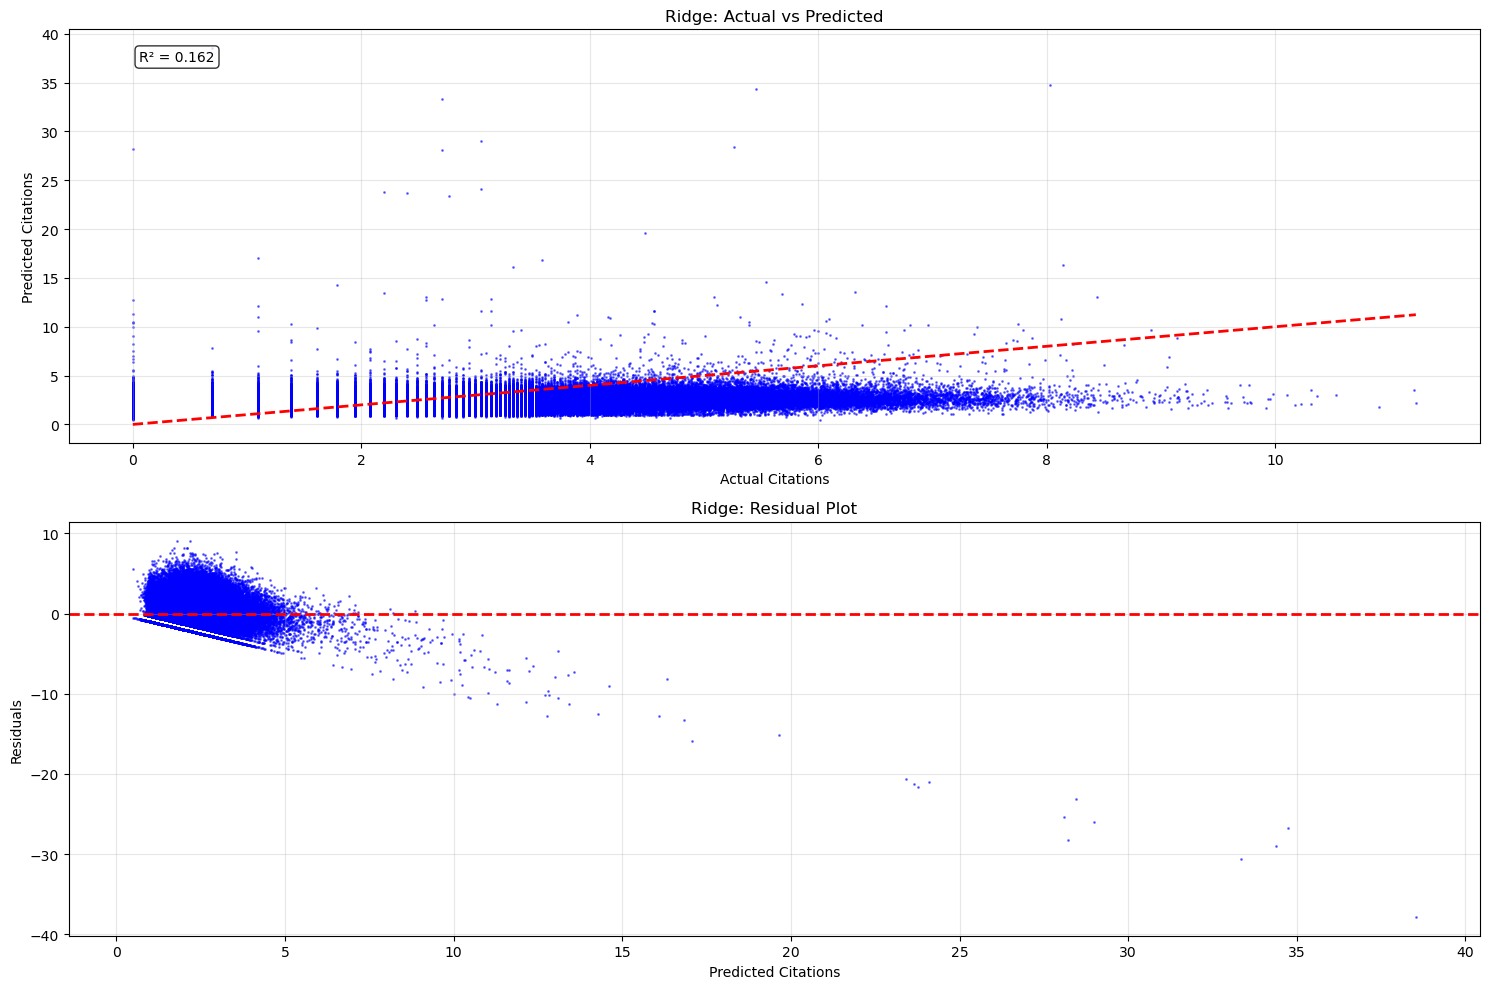

2025-07-20 18:43:09,584 - INFO - [MEM: 3944.9MB] - Evaluation plots saved to: data/plots/model_evaluation.png


Visualizations completed. Memory usage: 3805.4MB


<Figure size 1200x800 with 0 Axes>

In [ ]:


# ============================================================================
# BLOCK 10: Model Evaluation and Visualization
# ============================================================================

def create_evaluation_visualizations(models: Dict, results: Dict, y_test, X_test):
    """Create evaluation visualizations efficiently"""
    logger = setup_logging("evaluation_viz")
    logger.info("Creating evaluation visualizations")
    
    try:
        # Set up the plotting style
        plt.style.use('default')
        fig_size = (15, 10)
        
        # Create subplots
        n_models = len(models)
        fig, axes = plt.subplots(2, n_models, figsize=fig_size)
        if n_models == 1:
            axes = axes.reshape(2, 1)
        
        colors = ['blue', 'red', 'green', 'orange']
        
        for i, (model_name, model) in enumerate(models.items()):
            logger.info(f"Creating plots for {model_name}")
            
            # Get predictions
            if model_name == 'random_forest' and X_test.shape[1] > 10000:
                logger.warning(f"Skipping visualization for {model_name} due to memory constraints")
                continue
                
            if hasattr(model, 'predict'):
                if model_name == 'random_forest' and X_test.shape[1] <= 10000:
                    X_test_dense = X_test.toarray().astype(np.float32)
                    y_pred = model.predict(X_test_dense)
                    del X_test_dense
                else:
                    y_pred = model.predict(X_test)
            else:
                continue
            
            color = colors[i % len(colors)]
            
            # Plot 1: Actual vs Predicted
            axes[0, i].scatter(y_test, y_pred, alpha=0.5, color=color, s=1)
            axes[0, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            axes[0, i].set_xlabel('Actual Citations')
            axes[0, i].set_ylabel('Predicted Citations')
            axes[0, i].set_title(f'{model_name.title()}: Actual vs Predicted')
            axes[0, i].grid(True, alpha=0.3)
            
            # Add R² score to the plot
            r2 = results[model_name]['test_r2']
            axes[0, i].text(0.05, 0.95, f'R² = {r2:.3f}', 
                          transform=axes[0, i].transAxes, 
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Plot 2: Residuals
            residuals = y_test - y_pred
            axes[1, i].scatter(y_pred, residuals, alpha=0.5, color=color, s=1)
            axes[1, i].axhline(y=0, color='r', linestyle='--', lw=2)
            axes[1, i].set_xlabel('Predicted Citations')
            axes[1, i].set_ylabel('Residuals')
            axes[1, i].set_title(f'{model_name.title()}: Residual Plot')
            axes[1, i].grid(True, alpha=0.3)
            
            del y_pred, residuals
            force_garbage_collection()
        
        plt.tight_layout()
        
        # Save the plot
        plots_dir = CONFIG['DATA_DIR'] / 'plots'
        plots_dir.mkdir(exist_ok=True)
        plot_path = plots_dir / 'model_evaluation.png'
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        logger.info(f"Evaluation plots saved to: {plot_path}")
        
        # Create feature importance plot (for models that support it)
        plt.figure(figsize=(12, 8))
        
        for i, (model_name, model) in enumerate(models.items()):
            if hasattr(model, 'feature_importances_') and model_name == 'random_forest':
                # Get feature importances
                importances = model.feature_importances_
                
                # Focus on numerical features (first 7 features)
                numerical_importances = importances[:len(NUMERICAL_FEATURES_COLS)]
                
                plt.subplot(1, len(models), i+1)
                plt.bar(range(len(NUMERICAL_FEATURES_COLS)), numerical_importances)
                plt.xlabel('Feature Index')
                plt.ylabel('Importance')
                plt.title(f'{model_name.title()}: Feature Importance\n(Numerical Features Only)')
                plt.xticks(range(len(NUMERICAL_FEATURES_COLS)), 
                          [col[:10] for col in NUMERICAL_FEATURES_COLS], 
                          rotation=45)
                plt.grid(True, alpha=0.3)
        
        if any(hasattr(model, 'feature_importances_') for model in models.values()):
            plt.tight_layout()
            importance_plot_path = plots_dir / 'feature_importance.png'
            plt.savefig(importance_plot_path, dpi=150, bbox_inches='tight')
            plt.show()
            logger.info(f"Feature importance plot saved to: {importance_plot_path}")
        
    except Exception as e:
        logger.error(f"Error creating visualizations: {e}", exc_info=True)

# Create evaluation visualizations
print("\n" + "="*50)
print("CREATING EVALUATION VISUALIZATIONS")
print("="*50)

create_evaluation_visualizations(trained_models, model_results, y_test, X_test)
print(f"Visualizations completed. Memory usage: {get_memory_usage():.1f}MB")

In [ ]:


# ============================================================================
# BLOCK 11: Final Summary and Cleanup
# ============================================================================

def generate_final_summary(df: pd.DataFrame, models: Dict, results: Dict, config: Dict):
    """Generate final pipeline summary"""
    logger = setup_logging("final_summary")
    logger.info("Generating final pipeline summary")
    
    try:
        summary = {
            'pipeline_info': {
                'total_records_processed': len(df),
                'final_features': df.shape[1],
                'numerical_features': len(NUMERICAL_FEATURES_COLS),
                'tfidf_features_file': str(config['TFIDF_COMBINED_FEATURES_PATH']),
                'memory_limit_mb': config['MAX_MEMORY_MB'],
                'random_state': config['RANDOM_STATE']
            },
            'data_summary': {
                'target_variable': 'n_citation',
                'target_range': f"{df['n_citation'].min()} - {df['n_citation'].max()}",
                'target_mean': float(df['n_citation'].mean()),
                'target_median': float(df['n_citation'].median()),
                'target_std': float(df['n_citation'].std())
            },
            'model_performance': {},
            'feature_info': {
                'numerical_features': NUMERICAL_FEATURES_COLS,
                'text_fields_processed': ['title', 'abstract', 'keywords']
            }
        }
        
        # Add model performance
        for model_name, metrics in results.items():
            summary['model_performance'][model_name] = {
                'test_r2': float(metrics['test_r2']),
                'test_rmse': float(np.sqrt(metrics['test_mse'])),
                'test_mae': float(metrics['test_mae']),
                'training_time_seconds': float(metrics['training_time'])
            }
        
        # Save summary
        summary_path = config['DATA_DIR'] / 'pipeline_summary.json'
        import json
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        logger.info(f"Pipeline summary saved to: {summary_path}")
        
        # Print summary to console
        print("\n" + "="*60)
        print("PIPELINE EXECUTION SUMMARY")
        print("="*60)
        print(f"✓ Dataset processed: {summary['pipeline_info']['total_records_processed']:,} records")
        print(f"✓ Features created: {summary['pipeline_info']['final_features']} total")
        print(f"✓ Models trained: {len(models)}")
        print(f"✓ Memory usage: {get_memory_usage():.1f}MB")
        
        print(f"\nTarget Variable Statistics:")
        print(f"  Range: {summary['data_summary']['target_range']}")
        print(f"  Mean: {summary['data_summary']['target_mean']:.2f}")
        print(f"  Median: {summary['data_summary']['target_median']:.2f}")
        
        print(f"\nBest Model Performance:")
        best_model = max(results.keys(), key=lambda k: results[k]['test_r2'])
        best_r2 = results[best_model]['test_r2']
        best_rmse = np.sqrt(results[best_model]['test_mse'])
        print(f"  Model: {best_model}")
        print(f"  Test R²: {best_r2:.4f}")
        print(f"  Test RMSE: {best_rmse:.2f}")
        
        print(f"\nFiles Generated:")
        print(f"  ✓ {config['CLEANED_PARQUET_FILE']}")
        print(f"  ✓ {config['TFIDF_COMBINED_FEATURES_PATH'].name}")
        print(f"  ✓ {config['TFIDF_VECTORIZERS_PATH'].name}")
        print(f"  ✓ dblp_final_processed.parquet")
        print(f"  ✓ Model files in models/ directory")
        print(f"  ✓ Plots in plots/ directory")
        print(f"  ✓ pipeline_summary.json")
        
        return summary
        
    except Exception as e:
        logger.error(f"Error generating summary: {e}", exc_info=True)
        raise

# Generate final summary
print("\n" + "="*50)
print("GENERATING FINAL SUMMARY")
print("="*50)

final_summary = generate_final_summary(df_final, trained_models, model_results, CONFIG)

# Final cleanup
print("\n" + "="*50)
print("FINAL CLEANUP")
print("="*50)

# Clean up large variables
del X_train, X_test, y_train, y_test
del df_clean, df_features, df_final
del combined_tfidf, vectorizers
force_garbage_collection()

print(f"Pipeline completed successfully!")
print(f"Final memory usage: {get_memory_usage():.1f}MB")
print(f"Total execution time logged in individual step logs.")

print("\n" + "="*60)
print("MEMORY-EFFICIENT DBLP CITATION NETWORK PIPELINE COMPLETE")
print("="*60)

2025-07-20 18:43:09,626 - INFO - [MEM: 3660.4MB] - Generating final pipeline summary
2025-07-20 18:43:09,691 - INFO - [MEM: 3660.4MB] - Pipeline summary saved to: data/pipeline_summary.json



GENERATING FINAL SUMMARY

PIPELINE EXECUTION SUMMARY
✓ Dataset processed: 1,732,752 records
✓ Features created: 25 total
✓ Models trained: 1
✓ Memory usage: 3395.9MB

Target Variable Statistics:
  Range: 0 - 121860
  Mean: 39.47
  Median: 7.00

Best Model Performance:
  Model: ridge
  Test R²: 0.1625
  Test RMSE: 1.46

Files Generated:
  ✓ dblp_cleaned.parquet
  ✓ tfidf_combined_sparse_features.npz
  ✓ tfidf_vectorizers.pkl
  ✓ dblp_final_processed.parquet
  ✓ Model files in models/ directory
  ✓ Plots in plots/ directory
  ✓ pipeline_summary.json

FINAL CLEANUP
Memory: 4442.0MB -> 4403.0MB (freed: 39.0MB)
Pipeline completed successfully!
Final memory usage: 4403.0MB
Total execution time logged in individual step logs.

MEMORY-EFFICIENT DBLP CITATION NETWORK PIPELINE COMPLETE
